<a href="https://colab.research.google.com/github/Sinha-Abhinav-13/tictactoe/blob/master/sentiment_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import tweepy as tw
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import Dense, Dropout, concatenate, Bidirectional, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def wordcount_gen(df, category):
  combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
  wc = WordCloud(background_color='white', max_words=50, stopwords = STOPWORDS)
  plt.figure(figsize=(10,10))
  plt.imshow(wc.generate(combined_tweets))
  plt.title('{} Sentiment Words'.format(category), fontsize=20)
  plt.axis('off')
  plt.show()

In [ ]:
def preprocess_text(text):
  text = re.sub(r"[^a-zA-Z0-9]"," ", text)
  text = text.lower()
  text = text.split()
  text = [stemmer.stem(word) for word in text if not word in stop_words]
  text = " ".join(text)
  return text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Twitter_Data.csv')
#print(df1.columns)
df1['clean_text'] = df1['clean_text']
df1 = df1[['clean_text', 'category']]

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns = {'text':'clean_text', 'sentiment': 'category'})
df2['category'] = df2['category'].map({-1:-1.0,0:0.0,1:1.0})
df2['clean_text'] = df2['clean_text'].apply(preprocess_text)
df2 = df2[['clean_text', 'category']]

In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/finalSentimentdata2.csv')
df3 = df3.rename(columns = {'text':'clean_text', 'sentiment': 'category'})
#print(df3.head())
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy': 1.0})
df3['clean_text'] = df3['clean_text'].apply(preprocess_text)
df3 = df3[['clean_text', 'category']]

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/Tweets.csv')
df4 = df4.rename(columns = {'text':'clean_text', 'airline_sentiment': 'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive': 1.0})
df4['clean_text'] = df4['clean_text'].apply(preprocess_text)
df4 = df4[['clean_text', 'category']]

In [ ]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.dropna(axis=0, inplace=True)
df['category'] = df['category'].map({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [ ]:
#print(df['clean_text'].head())
print(df['clean_text'].isnull().sum())
#print(df['clean_text'].apply(len).describe())

0


<Axes: xlabel='category'>

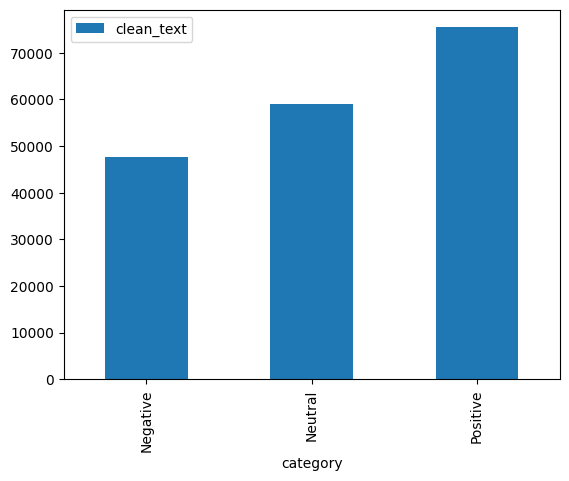

In [ ]:
df.groupby('category').count().plot(kind = 'bar')

<Axes: >

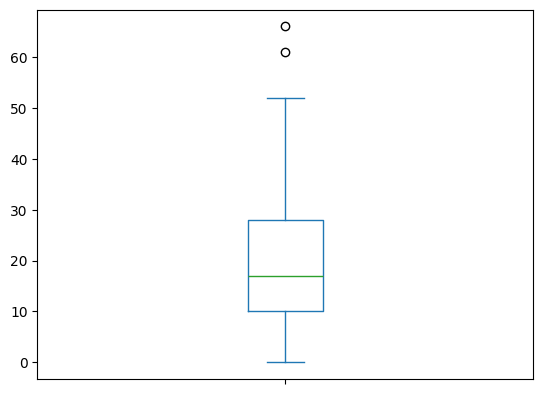

In [ ]:
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])
#print(tweet_len.describe())
tweet_len.plot(kind='box')

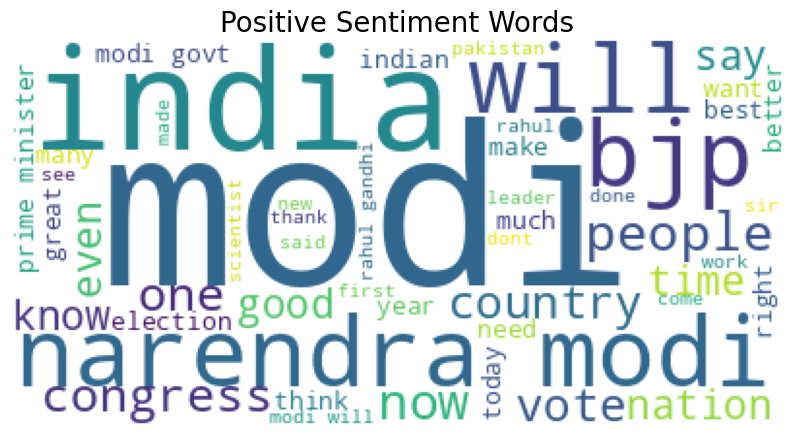

In [ ]:
wordcount_gen(df, 'Positive')

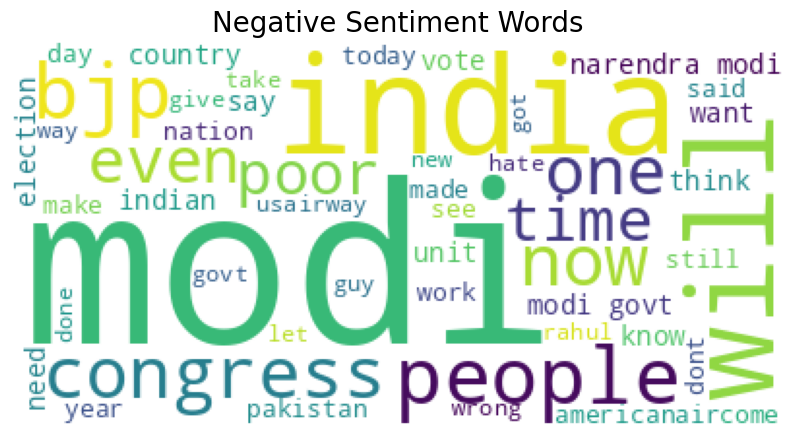

In [ ]:
wordcount_gen(df, 'Negative')

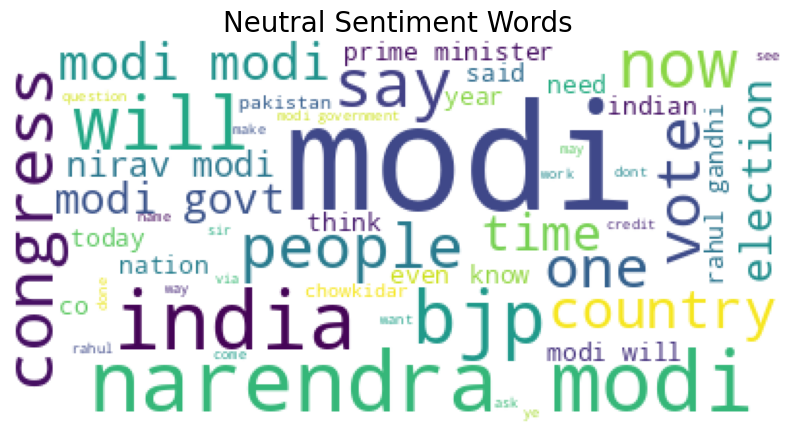

In [ ]:
wordcount_gen(df, 'Neutral')

In [ ]:
max_words = 5000
max_len = 50

In [ ]:
def tokenize_pad_sequences(text):
  tokenizer = Tokenizer(num_words=max_words, lower = True, split = ' ')
  tokenizer.fit_on_texts(text)
  X = tokenizer.texts_to_sequences(text)
  X = pad_sequences(X,padding = 'post', maxlen=max_len)
  return X, tokenizer

In [ ]:
X, tokenizer = tokenize_pad_sequences(df['clean_text'])

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (109397, 50) (109397, 3)
Validation Set -> (36466, 50) (36466, 3)
Test Set -> (36466, 50) (36466, 3)


In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate/epochs
momentum = 0.8

MODEL TRAINING USING RCNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape = (None, max_len))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


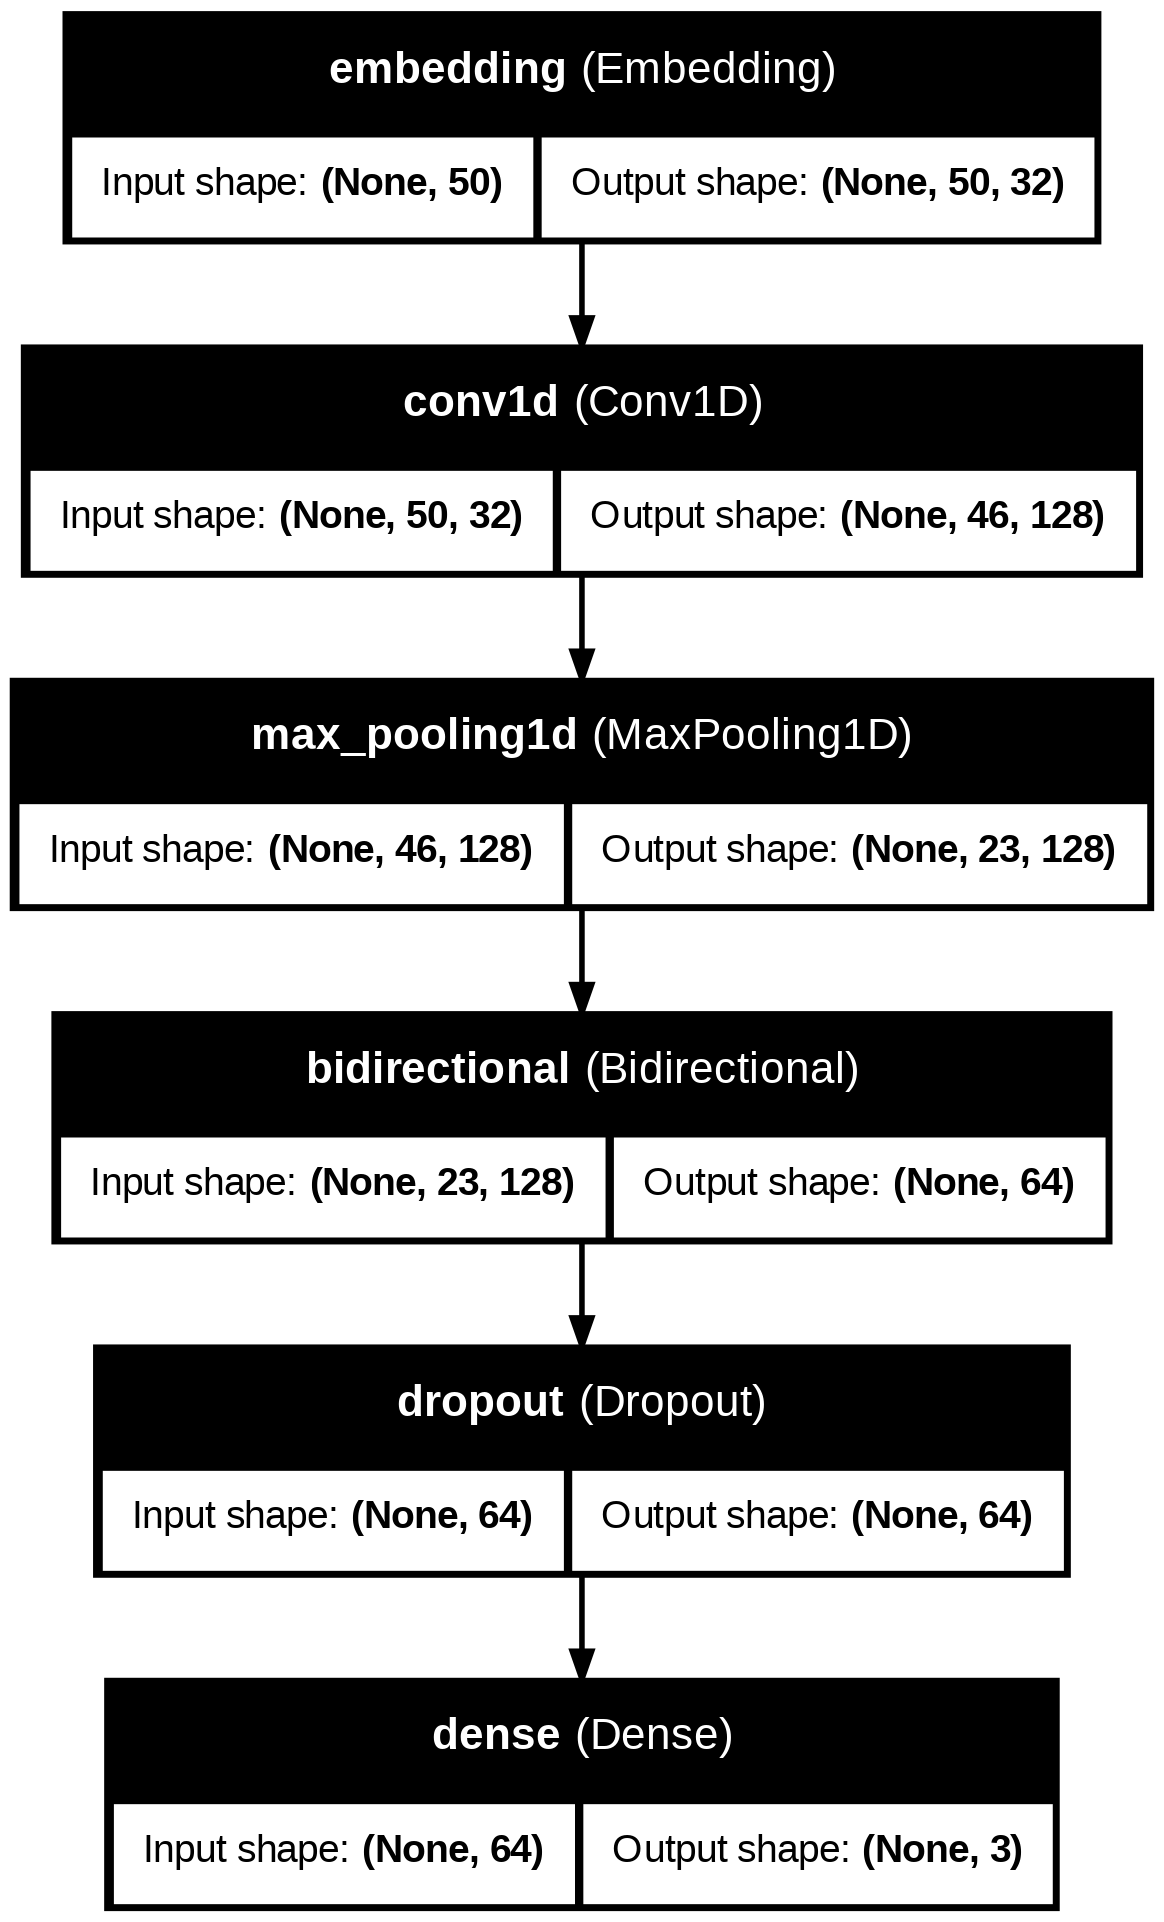

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 32)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 46, 128)             │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,019 (867.26 KB)

 Trainable params: 222,019 (867.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks = [early_stop])


Epoch 1/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 222s 62ms/step - accuracy: 0.6138 - loss: 0.8375 - val_accuracy: 0.8819 - val_loss: 0.3470
Epoch 2/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 206s 46ms/step - accuracy: 0.8885 - loss: 0.3486 - val_accuracy: 0.9083 - val_loss: 0.2923
Epoch 3/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 183s 41ms/step - accuracy: 0.9093 - loss: 0.2936 - val_accuracy: 0.9218 - val_loss: 0.2524
Epoch 4/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 171s 49ms/step - accuracy: 0.9221 - loss: 0.2608 - val_accuracy: 0.9234 - val_loss: 0.2486
Epoch 5/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 172s 40ms/step - accuracy: 0.9290 - loss: 0.2413 - val_accuracy: 0.9243 - val_loss: 0.2505
Epoch 6/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 180s 53ms/step - accuracy: 0.9321 - loss: 0.2290 - val_accuracy: 0.9294 - val_loss: 0.2359
Epoch 7/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 146s 36ms/step - accuracy: 0.9366 - loss: 0.2152 - val_accuracy: 0.9302 - val_loss: 0.2324
Epoch 8/20
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 123s 36ms/step - accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.2452930510044098
Test Accuracy: 0.9257664680480957


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test.values, axis=1)

1140/1140 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step


              precision    recall  f1-score   support

           0       0.88      0.90      0.89      9573
           1       0.93      0.94      0.94     11902
           2       0.95      0.93      0.94     14991

    accuracy                           0.93     36466
   macro avg       0.92      0.92      0.92     36466
weighted avg       0.93      0.93      0.93     36466

[[ 8663   394   516]
 [  490 11176   236]
 [  673   398 13920]]


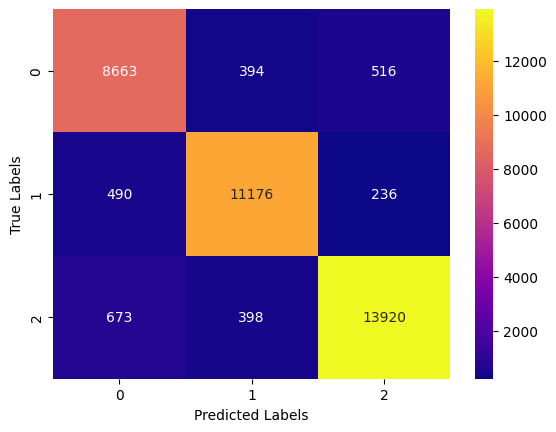

In [ ]:
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model.save('sentimental_analysis_model.keras')

In [ ]:
model = load_model('sentimental_analysis_model.keras')

In [ ]:
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [ ]:
epochs = range(1, len(accuracy) + 1)

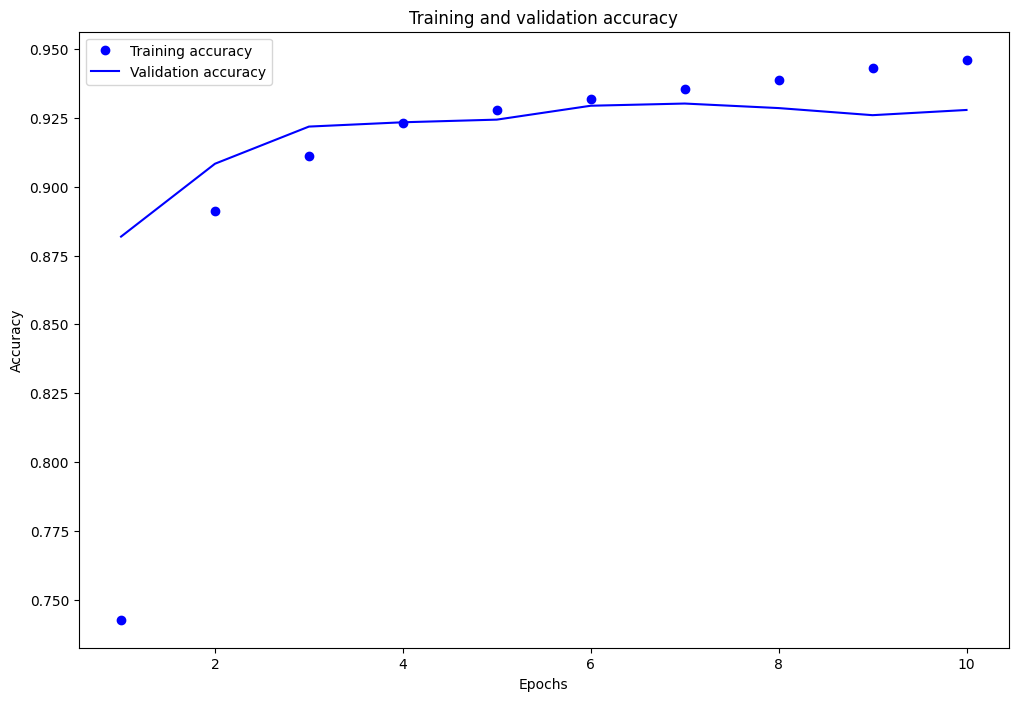

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

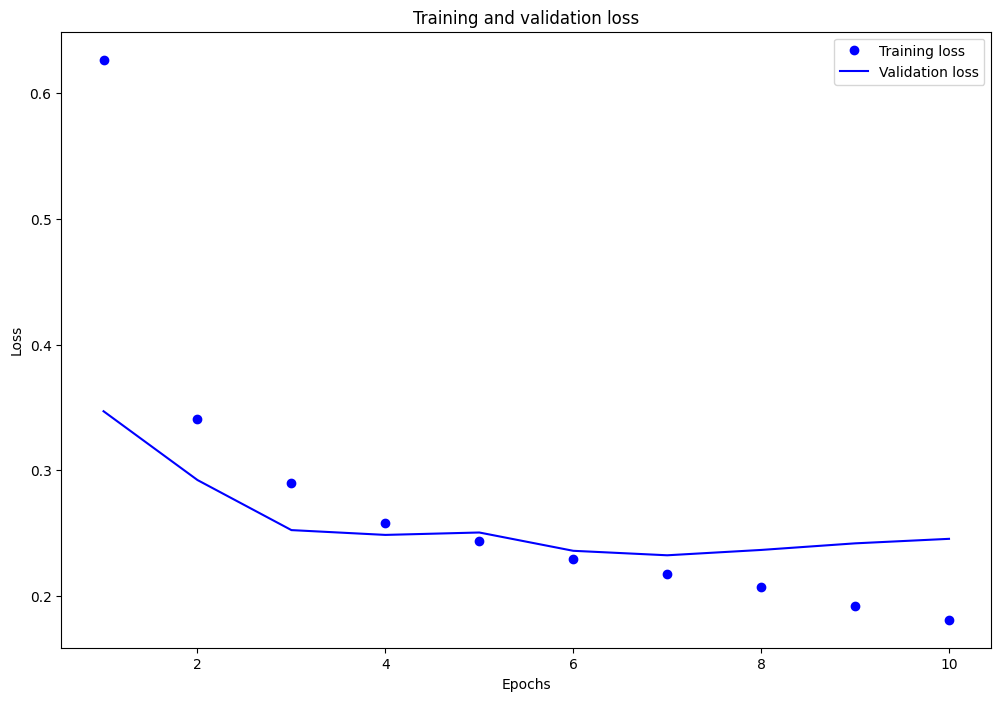

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('sentimental_analysis_model.keras')
real_time_input = ["Great effort by the team."]

real_time_sequences = tokenizer.texts_to_sequences(real_time_input)
real_time_padded_sequences = pad_sequences(real_time_sequences, padding='post', maxlen=max_len)

predictions = model.predict(real_time_padded_sequences)

predicted_classes = np.argmax(predictions, axis=1)
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_labels = [sentiment_labels[pred] for pred in predicted_classes]

for sentence, label in zip(real_time_input, predicted_labels):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {label}")


ValueError: File not found: filepath=sentimental_analysis_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from transformers import pipeline

# Load pre-trained sentiment-analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis")

# Example sentence
sentence = "Despite the delay, the customer service was excellent and made the experience much better."

# Perform sentiment analysis
result = sentiment_analysis(sentence)

print(result)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9995526671409607}]


In [ ]:
import tweepy

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJdpxgEAAAAAnTiwo3v8lnIeJh0GRiAUYRa2GJQ%3DdHjcSQE4w8pJ6oAXrf7qJw8jQiR7HqPrzEcMHNMNOVpPrH6nAu'

client = tweepy.Client(bearer_token=bearer_token)

query = 'dsu'
response = client.search_recent_tweets(query=query, max_results=10)

for tweet in response.data:
    print(tweet.text)


TooManyRequests: 429 Too Many Requests
Too Many Requests

In [ ]:
model = load_model('sentimental_analysis_model.keras')

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
   tokenizer = pickle.load(handle)

In [ ]:
max_len = 50

In [ ]:
def predict_sentiment(tweet_text):
  tweet_sequences = tokenizer.texts_to_sequences([tweet_text])
  tweet_padded_sequences = pad_sequences(tweet_sequences, padding='post', maxlen=max_len)
  predictions = model.predict(tweet_padded_sequences)
  predicted_classes = np.argmax(predictions, axis=1)
  sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
  predicted_label = sentiment_labels[predicted_classes[0]]
  return predicted_label

In [ ]:
for tweet in response.data:
  tweet_text = tweet.text
  sentiment = predict_sentiment(tweet_text)
  print(f"Tweet: {tweet_text}")
  print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Tweet: @CEOlaser’s High Energy Laser (2J, 10Hz, 532nm) is used in the European Union’s Extreme Light Infrastructure Beamlines #MachineLearning experiment.

🔍 Learn more about the ELI Beamlines machine learning experiment here: https://t.co/PEzFoc2JQZ 

#LaserTechnology #HighEnergyL ... https://t.co/opf2eTD0Ss
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Tweet: RT @Ronycoder: Are you struggling to pay a huge amount on paid courses?

I'm giving you access to 20+ FREE Courses

1. Artificial Intellige…
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Tweet: RT @Ronycoder: Are you struggling to pay a huge amount on paid courses?

I'm giving you access to 20+ FREE Courses

1. Artificial Intellige…
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Tweet: RT @Ronycoder: Are you struggling to pay a huge amount on paid courses?

I'm giving you access to 20+ FREE Courses

1. Artificial Intellige…